# Lib. Prep.

In [1]:
import pandas as pd
import numpy as np
from tabula import read_pdf
from tabulate import tabulate
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os, re, cv2, pytesseract, time
from selenium import webdriver
from selenium.webdriver.common.by import By
from io import StringIO
import matplotlib.ticker as ticker
from dotenv import load_dotenv
load_dotenv()
DATA_DIR = os.getenv('DATA_DIR')
PYTESSERACT_DIR = os.getenv('PYTESSERACT_DIR')

# Get Data

## Data UMK

In [2]:
umk = pd.read_excel('data/umk_id_2023.xlsx', header=None)
umk

,0
0,Aceh
1,Aceh Barat
2,3413666
3,Aceh
4,Aceh Barat Daya
...,...
1420,Kabupaten Tana Tidung
1421,3370205
1422,Kalimantan Utara
1423,Kota Tarakan


In [3]:
provs = [i for i in range(1425) if i%3==0]
kabkot = [i for i in range(1425) if i%3==1]
umk_val = [i for i in range(1425) if i%3==2]
umk_2023 = pd.DataFrame()
umk_2023['provinsi'] = umk.loc[provs].reset_index(drop=True)
umk_2023['kab_kota'] = umk.loc[kabkot].reset_index(drop=True)
umk_2023['umk'] = umk.loc[umk_val].astype('float').reset_index(drop=True)
umk_2023.provinsi = umk_2023.provinsi.apply(lambda x:x.upper())
umk_2023.provinsi.replace({'D. I. YOGYAKARTA':'DI YOGYAKARTA'},inplace=True)
umk_2023.info()
umk_2023

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   provinsi  475 non-null    object 
 1   kab_kota  475 non-null    object 
 2   umk       475 non-null    float64
dtypes: float64(1), object(2)
memory usage: 11.3+ KB


,provinsi,kab_kota,umk
0,ACEH,Aceh Barat,3413666.00
1,ACEH,Aceh Barat Daya,3413666.00
2,ACEH,Aceh Besar,3413666.00
3,ACEH,Aceh Jaya,3413666.00
4,ACEH,Aceh Selatan,3413666.00
...,...,...,...
470,KALIMANTAN UTARA,Kabupaten Bulungan,3362895.51
471,KALIMANTAN UTARA,Kabupaten Malinau,3494498.55
472,KALIMANTAN UTARA,Kabupaten Nunukan,3319134.00
473,KALIMANTAN UTARA,Kabupaten Tana Tidung,3370205.00


## Data UMP

In [4]:
# Read the image
image = cv2.imread('data/ump_2023.png', cv2.IMREAD_GRAYSCALE)

# tresholding to get black and white image
(thresh, im_bw) = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
thresh = 127
im_bw = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)[1]

# reverse black and white
im_bw = 255-im_bw

# saving for checking 
cv2.imwrite(f'{DATA_DIR}data_4.jpg',im_bw)

# Apply OCR 
pytesseract.pytesseract.tesseract_cmd = PYTESSERACT_DIR
data = pytesseract.image_to_string(im_bw)

# # Print the extracted data
# print(data)

# Split the data into lines
lines = data.split("\n")

# Use a regular expression to split each line into strings and numbers
pattern = r"([A-Za-z\s]+)([0-9\,\.]+)"

strings = []
numbers = []

for line in lines:
  match = re.search(pattern, line)
  if match:
    strings.append(match.group(1).upper().strip())
    numbers.append(float(match.group(2).replace('.','').replace(',','')))

## for checking
# print("Strings:", strings)
# print("Numbers:", numbers)

ump_2023 = pd.DataFrame({'Provinsi':strings, '2023':numbers})
# df['2023'] = df['2023'].astype('float')
ump_2023.drop(0, inplace=True)


dict_prov = {
  'NIB':'NUSA TENGGARA BARAT',
  'NTT': 'NUSA TENGGARA TIMUR',
  'BANGKA BELITUNG': 'KEPULAUAN BANGKA BELITUNG',
  'YOGYAKARTA': 'DI YOGYAKARTA',
  'JAKARTA': 'DKI JAKARTA'
}

ump_2023.Provinsi.replace(dict_prov, inplace=True)
ump_2023.set_index('Provinsi', inplace=True)

# manual fill
ump_2023.loc['KALIMANTAN BARAT', '2023'] = 2608602.0
ump_2023.loc['SULAWESI BARAT', '2023'] = 2871795.0
ump_2023.loc['PAPUA BARAT', '2023'] = 3282000.0

ump_2023.reset_index(inplace=True)

ump_2023

,Provinsi,2023
0,ACEH,3413666.0
1,SUMATERA UTARA,2710493.0
2,SUMATERA BARAT,2742476.0
3,RIAU,3191662.0
4,JAMBI,2943033.0
5,SUMATERA SELATAN,3404177.0
6,BENGKULU,2418280.0
7,LAMPUNG,2633284.0
8,KEPULAUAN BANGKA BELITUNG,3498479.0
9,KEPULAUAN RIAU,3279194.0


In [5]:
image

array([[207, 207, 207, ..., 207, 207, 207],
       [207, 207, 207, ..., 207, 207, 207],
       [207, 207, 207, ..., 207, 207, 207],
       ...,
       [ 46,  46,  46, ...,  46,  46,  46],
       [ 46,  46,  46, ...,  46,  46,  46],
       [ 46,  46,  46, ...,  46,  46,  46]], dtype=uint8)

In [6]:
java = ["BANTEN", "DKI JAKARTA", "JAWA BARAT", "JAWA TENGAH", "DI YOGYAKARTA", "JAWA TIMUR"]
java_data = umk_2023.query('provinsi == @java').reset_index(drop=True)
java_data.drop(index=range(28,36), inplace=True)
java_data

,provinsi,kab_kota,umk
0,DKI JAKARTA,DKI JAKARTA,4901798.0
1,JAWA BARAT,KOTA BEKASI,5158248.0
2,JAWA BARAT,KARAWANG,5176179.0
3,JAWA BARAT,BEKASI,5137575.0
4,JAWA BARAT,PURWAKARTA,4464675.0
...,...,...,...
117,BANTEN,Serang,4090799.0
118,BANTEN,Kabupaten Tangerang,4527688.0
119,BANTEN,Kabupaten Serang,4492961.0
120,BANTEN,Kabupaten Pandeglang,2980351.0


In [7]:
# Combining Data
ump_umk = pd.merge(umk_2023, ump_2023[['Provinsi', '2023']], how='left', left_on='provinsi', right_on='Provinsi').rename(columns={'2023': 'ump'}).drop(columns='Provinsi').copy()
ump_umk['diff'] = ump_umk['umk']-ump_umk['ump']
ump_umk['pct_diff'] = round((ump_umk['umk']-ump_umk['ump'])/ump_umk['ump']*100,2)

# drop duplikat banten di jateng
ump_umk.drop(index=range(325,333), inplace=True)
ump_umk

,provinsi,kab_kota,umk,ump,diff,pct_diff
0,ACEH,Aceh Barat,3413666.00,3413666.0,0.00,0.00
1,ACEH,Aceh Barat Daya,3413666.00,3413666.0,0.00,0.00
2,ACEH,Aceh Besar,3413666.00,3413666.0,0.00,0.00
3,ACEH,Aceh Jaya,3413666.00,3413666.0,0.00,0.00
4,ACEH,Aceh Selatan,3413666.00,3413666.0,0.00,0.00
...,...,...,...,...,...,...
470,KALIMANTAN UTARA,Kabupaten Bulungan,3362895.51,3251702.0,111193.51,3.42
471,KALIMANTAN UTARA,Kabupaten Malinau,3494498.55,3251702.0,242796.55,7.47
472,KALIMANTAN UTARA,Kabupaten Nunukan,3319134.00,3251702.0,67432.00,2.07
473,KALIMANTAN UTARA,Kabupaten Tana Tidung,3370205.00,3251702.0,118503.00,3.64


# Viz

## Top-N - Bottom-N

C:\Users\ACER\AppData\Local\Temp\ipykernel_20796\3744463733.py:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('result/top_bottom.png', bbox='tight', dpi=1000, transparent=True)


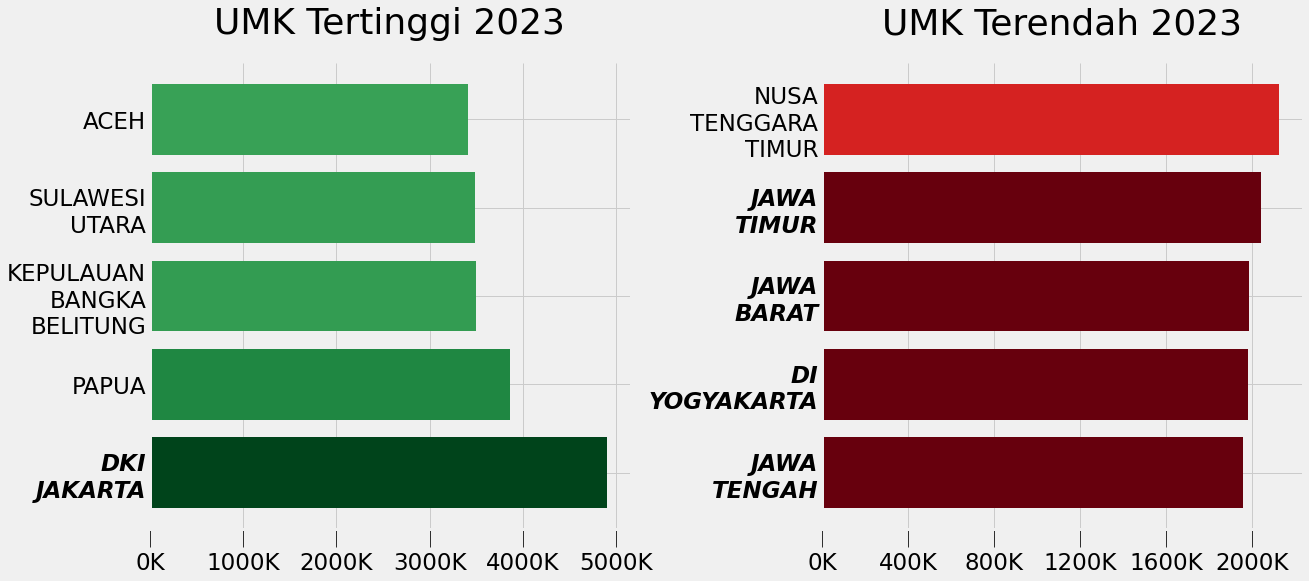

In [8]:
top_n = ump_2023.nlargest(5, columns='2023').reset_index(drop=True)
top_n.Provinsi = top_n.Provinsi.apply(lambda x:x.replace(' ', '\n'))
bottom_n = ump_2023.nsmallest(5, columns='2023').reset_index(drop=True)
bottom_n.Provinsi = bottom_n.Provinsi.apply(lambda x:x.replace(' ', '\n'))

plt.style.use('fivethirtyeight')
# Define the formatter function
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x*1e-3)

# Create a color map
cmap1 = plt.get_cmap('Greens')
normalize1 = plt.Normalize(vmin=500000, vmax=top_n['2023'].max())
cmap2 = plt.get_cmap('Reds_r')
normalize2 = plt.Normalize(vmin=bottom_n['2023'].max()*.98, vmax=bottom_n['2023'].max()*1.05)
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['xtick.major.size'] = 18
plt.rcParams['font.size'] = 23

plt.figure(figsize=(20,8))
plt.subplots_adjust(wspace=.4, left=.15)
plt.subplot(1,2,1)
plt.barh(top_n.Provinsi, top_n['2023'], color=cmap1(normalize1(top_n['2023'].values)))
plt.title('UMK Tertinggi 2023', y=1.05)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(thousands))
plt.gca().yaxis.get_ticklabels()[0].set_weight('bold')
plt.gca().yaxis.get_ticklabels()[0].set_style('italic')
for j, spine in enumerate(plt.gca().spines.values()):
    if j%2==0: continue
    spine.set_visible(False)

plt.subplot(1,2,2)
plt.barh(bottom_n.Provinsi, bottom_n['2023'], color=cmap2(normalize2(bottom_n['2023'].values)))
plt.title('UMK Terendah 2023', y=1.05)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(thousands))
for i in range(4):
    plt.gca().yaxis.get_ticklabels()[i].set_weight('bold')
    plt.gca().yaxis.get_ticklabels()[i].set_style('italic')
plt.gca().xaxis.set_ticks(np.arange(0, bottom_n['2023'].max(), 400000))


for j, spine in enumerate(plt.gca().spines.values()):
    if j%2==0: continue
    spine.set_visible(False)
plt.savefig('result/top_bottom.png', bbox='tight', dpi=1000, transparent=True)


## Boxplot

C:\Users\ACER\AppData\Local\Temp\ipykernel_20796\2767211335.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('result/boxplot.png', bbox='tight', dpi=1000, transparent=True)


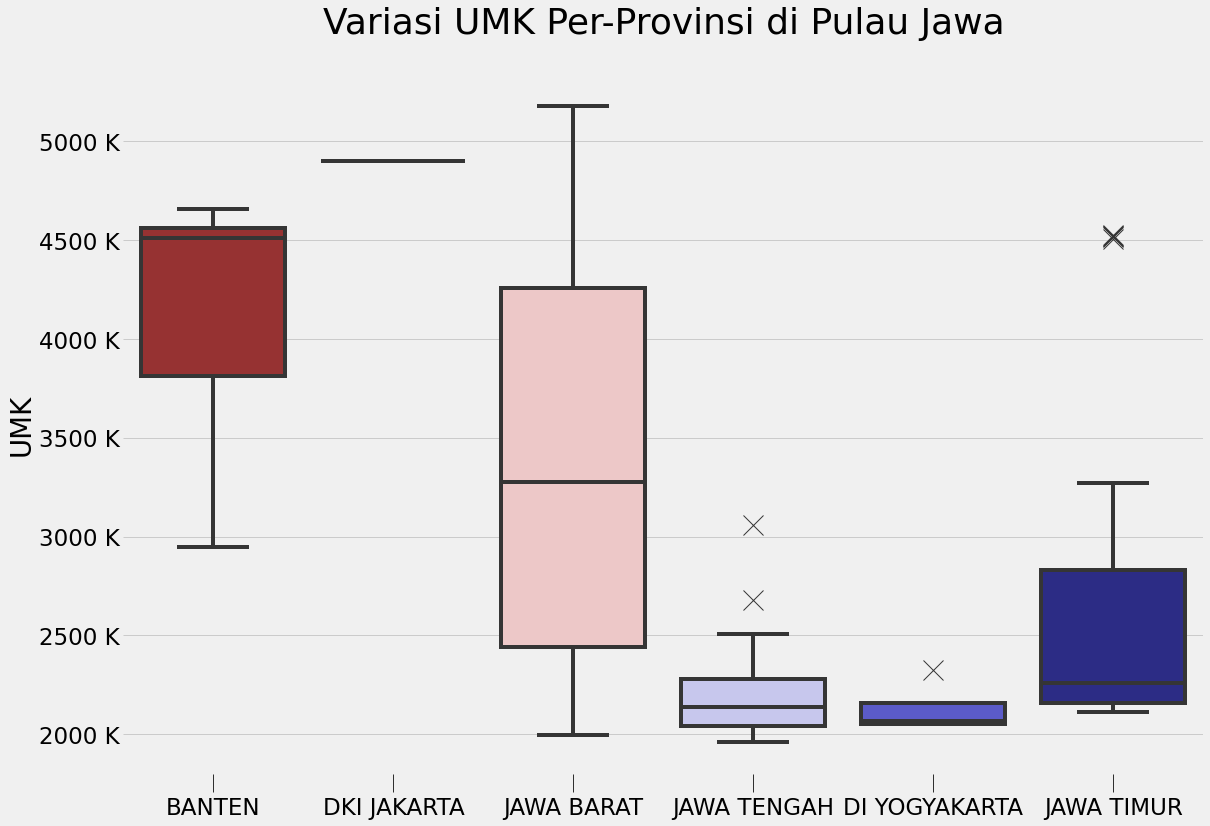

In [10]:
plt.style.use('fivethirtyeight')
# Define the formatter function
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0f K' % (x*1e-3)

plt.style.use('fivethirtyeight')
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['xtick.major.size'] = 18
plt.rcParams['font.size'] = 23
fig, ax = plt.subplots(figsize=(20,12))
fig.subplots_adjust(left=0.2)
ax = sns.boxplot(y=java_data.umk, x=java_data.provinsi, 
                 order=['BANTEN', 'DKI JAKARTA', 'JAWA BARAT', 'JAWA TENGAH', 'DI YOGYAKARTA', 'JAWA TIMUR'],
                 fliersize=20, saturation=.5, palette='seismic_r', flierprops={"marker": "x"},)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(thousands))
ax.axes.set_title('Variasi UMK Per-Provinsi di Pulau Jawa', y= 1.05)
ax.axes.set_xlabel('')
ax.axes.set_ylabel('UMK')

for j, spine in enumerate(ax.axes.spines.values()):
    # if j%2==0: continue
    spine.set_visible(False)
fig.savefig('result/boxplot.png', bbox='tight', dpi=1000, transparent=True)